In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report

In [2]:
path = 'data/healthcare-dataset-stroke-data.csv'

dataframe = pd.read_csv(path)
dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
bins = [0, 2, 18, 40, 60, 82]
labels = ['newborn', 'child', 'young adult', 'middle age', 'senior']

dataframe['age_group'] = pd.cut(dataframe['age'],bins = bins,labels = labels,right=True)

In [4]:
bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_81067/474049611.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()


In [5]:
for key,val in bmi_mean_by_age.items():
    mask = (dataframe['age_group'] == key) & (dataframe['bmi'].isna())
    dataframe.loc[mask,'bmi'] = val
    
dataframe['bmi'] = dataframe['bmi'].round(2)

#discretization and smoothing for bmi
# Define bin edges from 10 to 100 with a step of 10
bin_edges_bmi = np.arange(10, 100 + 5, 5)  # [10, 20, 30, ..., 100]

# Create BMI bins
dataframe['bmi_bin'] = pd.cut(dataframe['bmi'], bins=bin_edges_bmi, include_lowest=True)

# Replace BMI values with bin means
dataframe['bmi'] = dataframe.groupby('bmi_bin')['bmi'].transform('mean')


/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_81067/959797956.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe['bmi'] = dataframe.groupby('bmi_bin')['bmi'].transform('mean')


In [6]:
dataframe = dataframe.drop(['age_group','bmi_bin','id'],axis=1)
dataframe

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,37.245200,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,27.747544,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.295168,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,32.295168,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,22.759631,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,27.747544,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,37.245200,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,32.295168,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,27.747544,formerly smoked,0


In [7]:
dataframe['gender'] = dataframe['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
dataframe['Residence_type'] = dataframe['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
dataframe['work_type'] =dataframe['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_81067/3508636352.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe['gender'] = dataframe['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_81067/3508636352.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe['Residence_type'] = dataframe['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_81067/35086363

Let's take a look on on worktype and anount of stroke .


We can notice that the number of stroke cases in the private sector neither then in other type of work type. So this feature could be useful.

In [8]:
#Encode categorical values

categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['ever_married', 'smoking_status']

In [9]:
encoder =OrdinalEncoder()

dataframe_cp = dataframe.copy()
dataframe_cp[categorical_columns] = encoder.fit_transform(dataframe[categorical_columns])

In [10]:
dataframe_cp = dataframe_cp.round(2)
dataframe_cp

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1.0,0,1,228.69,37.25,1.0,1
1,1,61.0,0,0,1.0,1,0,202.21,27.75,2.0,1
2,0,80.0,0,1,1.0,0,0,105.92,32.30,2.0,1
3,1,49.0,0,0,1.0,0,1,171.23,32.30,3.0,1
4,1,79.0,1,0,1.0,1,0,174.12,22.76,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,1,80.0,1,0,1.0,0,1,83.75,27.75,2.0,0
5106,1,81.0,0,0,1.0,1,1,125.20,37.25,2.0,0
5107,1,35.0,0,0,1.0,1,0,82.99,32.30,2.0,0
5108,0,51.0,0,0,1.0,0,0,166.29,27.75,1.0,0


In [11]:
# Separate features and labels
X = dataframe_cp.drop('stroke', axis=1)
y = dataframe_cp['stroke']

# Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4688,0,31.00,0,0,0.0,1,0,64.85,22.76,0.0
4478,0,40.00,0,0,1.0,1,0,65.29,27.75,2.0
3849,1,8.00,0,0,0.0,255,1,74.42,22.76,0.0
4355,1,79.00,1,0,1.0,1,0,76.64,17.95,2.0
3826,1,75.00,0,0,1.0,2,0,94.77,27.75,2.0
...,...,...,...,...,...,...,...,...,...,...
3605,0,1.88,0,0,0.0,255,0,143.97,17.95,0.0
4934,0,1.32,0,0,0.0,255,0,107.02,17.95,0.0
4835,0,49.00,1,0,1.0,1,0,119.30,32.30,1.0
4105,1,56.00,0,0,0.0,1,1,128.63,22.76,3.0


### SMOTE algorithm for the imbalanced data

In [13]:
smote = SMOTE(random_state=42,sampling_strategy=0.5)
X_res_train, y_res_train = smote.fit_resample(X_train, y_train)


In [14]:
#number of stroke data after smote 
print((y_res_train==1).sum())

1950


I want to evaluate how the model performs when using **all available parameters** versus using only a subset of key features such as **BMI, glucose level, and age**.   
Based on both the visualization and association rule analysis, these particular features appear to have a stronger influence on stroke occurrence. Therefore, comparing model performance on the full dataset versus the reduced feature set could provide valuable insights into which parameters are most predictive and whether a simpler model could achieve similar results.

In [15]:
X_train_dropped = X_res_train.drop(columns=['Residence_type','work_type','ever_married','heart_disease','hypertension'])
X_test_dropped = X_test.drop(columns=['Residence_type','work_type','ever_married','heart_disease','hypertension'])

To the model added the normalization for the values, because there is some large distribution of values. So i used the standart scaler that scale the values so there mean is 0 and variance is 1. That fits becase the values has a normal distribution.   
In logistic regression , i use the regularization so the model will punished on the wrong prediction.    
L2 is the Ridge algorithm for regularization is trying to minimize the large weights by penalizing the squared magnitude of weights **labmda*Sigma(w^2_i)*** .So it keeps all features but shrinks weights closer to zero. *lamda* = 1/C, So smaller  C - stronger regularization, large C - weaker regularization.

In [39]:
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.01,penalty='l2',random_state=42))])

In [40]:
#model 1
logreg_pipeline.fit(X_res_train,y_res_train)
y_probs = logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred = logreg_pipeline.predict(X_test)

In [41]:
#model 2
logreg_pipeline.fit(X_train_dropped,y_res_train)
y_probs_d = logreg_pipeline.predict_proba(X_test_dropped)[:, 1]
y_pred_d = logreg_pipeline.predict(X_test_dropped)

AUC score: 0.7886088709677419 0.7129872311827956


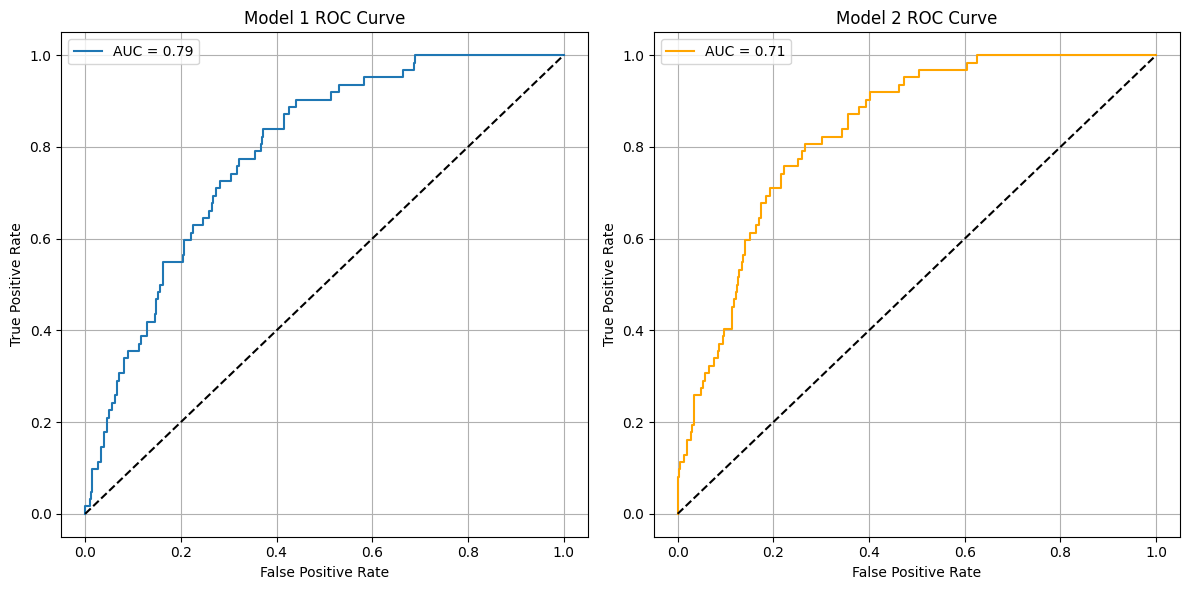

In [45]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fpr_1,tpr_1,thresholds_1 = roc_curve(y_test,y_probs_d)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
auc_1 = roc_auc_score(y_test,y_pred_d)

print("AUC score:", auc,auc_1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Model 1
axes[0].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title("Model 1 ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid()

# Model 2
axes[1].plot(fpr_1, tpr_1, label=f"AUC = {auc_1:.2f}", color='orange')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("Model 2 ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


From the two ROC curve plots, we can observe that Model 1 (trained on all parameters) has a higher AUC than Model 2, which was trained on a reduced set of features after feature selection.   
The AUC score reflects how well the model can distinguish between the positive and negative classes — a higher AUC indicates better ability to correctly identify positive cases.

In [43]:
print(classification_report(y_test, y_pred)),print(classification_report(y_test,y_pred_d))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       960
           1       0.17      0.37      0.23        62

    accuracy                           0.85      1022
   macro avg       0.56      0.63      0.58      1022
weighted avg       0.91      0.85      0.88      1022

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       960
           1       0.21      0.56      0.30        62

    accuracy                           0.84      1022
   macro avg       0.59      0.71      0.61      1022
weighted avg       0.92      0.84      0.87      1022



(None, None)

To analyze the model's performance, it's important to look beyond just accuracy and consider metrics like recall and precision.   
**Recall** measures the model’s sensitivity — that is, how well it identifies actual positive cases. It is the ratio of true positives (TP) to the sum of true positives and false negatives (FN), helping us understand how effectively the model captures positive instances.   
**Precision**, on the other hand, measures the proportion of positive predictions that are actually correct. It is the ratio of true positives to the sum of true positives and false positives (FP), indicating how reliable the model's positive predictions are.

Could be observed that the accuracy of the model is almost the same. So we analyse the precision and recall metrics.   
Let's take a look on **recall**:   
**Model 1** - 0.37 so that's mean that model 1 can identify only 37% positive cases from the whole positive data. Tha's not good rate, that mean that model is struggles to identify the positive class , and there is a lot mismathes of data with the positive class.
**Model 2** - 0.56 so that's mean that model 1 can identify only 56% positive cases from the whole positive data. That's better then the model 1, but there is a trade off of such good rate.

Let's take a look on **precision**:   
**Model 1** - 0.17 so that's mean that model 1 can identify only 17% actual positive cases , so there is the 73% that predictited as positive but the actual label is negative, and there is a lot. 
**Model 2** - 0.21 so that's mean that model 1 can identify only 21% actual positive cases , we see that's not better than the model 1 ,there is a lot of mismaches . 


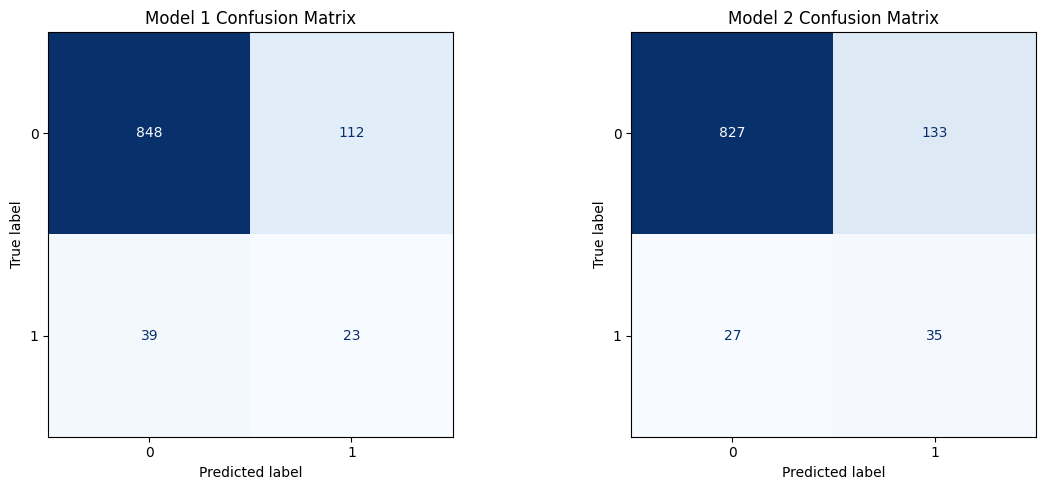

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Model 1
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], colorbar=False,cmap=plt.cm.Blues)
axes[0].set_title("Model 1 Confusion Matrix")

# Model 2
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_d, ax=axes[1], colorbar=False,cmap=plt.cm.Blues)
axes[1].set_title("Model 2 Confusion Matrix")

plt.tight_layout()
plt.show()


In conclusion:
While analyzing model perfomence not only the accuracy should be taken into account. Observed there is the problems with the mismatches of positive class, and predicition the positive label when the actual is negative.

In model 2 even I have done the feature selection and seems like the rate of preccision and recall metrics higher than the model 1, but there is the cost that model 2 predicts more data samples as positive when it's negative and it's crucial in a case of Stroke Prediction. But can identify more positive data samples from all positive data samples, but there is still a problem. 

Both models are struggeling with right prediction of the positive class.   
One of the major problem could be that data set was imbalanced and I've made it balanced using the SMOTE technique, so it's still artificial data of the positive class, and maybe it's not good enough or various to learn the strong patterns which indicates the stroke. 
When i tried the to train the Logistic regression model on imbalanced class, it's even didn't recognize the positive class at all, so it's still improvment with the artificial data.